# Image classification with Vision Transformer

This code follows "[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)" tutorial of Keras.
We made some editions to make this code able to run with Keras 2 (the version of Keras on Google Colab on check date 3 May 2024) and match the ViT architecture proposed by [AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://openreview.net/pdf?id=YicbFdNTTy)


## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

# Baseline setup

In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras
# import keras
from keras import layers
# from keras import ops

import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


169001437/169001437 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64  # d_k and d_v in each head
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier
dropout_rate = 0.1

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = images.shape
        batch_size = tf.shape(images)[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        p_s = [1, self.patch_size, self.patch_size, 1]
        patches = tf.image.extract_patches(images, sizes=p_s, strides=p_s, rates=[1,1,1,1], padding='VALID')

        patches = tf.reshape(patches, (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


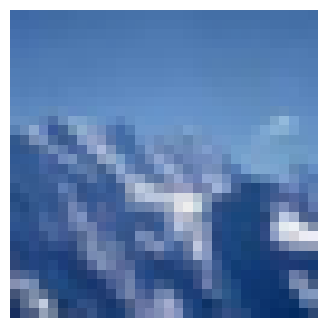

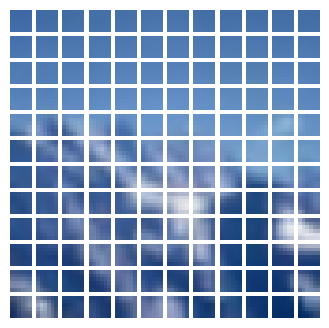

In [ ]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches+1
        self.cls_token = tf.Variable(initial_value=tf.random.normal([1, 1, projection_dim]))
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims( 
            tf.range(start=0, limit=self.num_patches, delta=1), axis=0
        )
        bz = tf.shape(patch)[0]
        cls_tokens = tf.repeat(self.cls_token, bz, axis=0)
        projected_patches = self.projection(patch)
        projected_token = tf.concat([cls_tokens, projected_patches], axis=1)
        encoded = projected_token + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

The original implementation of ViT model in [Keras tutorial](https://keras.io/examples/vision/image_classification_with_vision_transformer/) takes all the outputs of the final Transformer block, then
reshapes with `layers.Flatten()` and uses it as the image
representation input to the classifier head.

However, in this tutorial, we follow the architecture in [ViT paper](https://openreview.net/pdf?id=YicbFdNTTy), which take only representation of *cls token* in the final Transformer block and use it as the image
representation input to the classifier head.

In [ ]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from keras.backend import softmax

In [ ]:

def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    # print(augmented.shape)
    patches = Patches(patch_size)(augmented)
    # print(patches.shape)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
    encoded_patches = encoded_patches[:, 0]  # encoded feature of cls token
    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:
def plot_history(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
vit_classifier = create_vit_classifier()

In [ ]:
optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

vit_classifier.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "/tmp/checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = vit_classifier.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[checkpoint_callback],
)

plot_history(history, "loss")
plot_history(history, "top-5-accuracy")

Epoch 1/100
176/176 [==============================] - 89s 366ms/step - loss: 4.2593 - accuracy: 0.0467 - top-5-accuracy: 0.1798 - val_loss: 3.9000 - val_accuracy: 0.0946 - val_top-5-accuracy: 0.2916
Epoch 2/100
176/176 [==============================] - 63s 357ms/step - loss: 3.9189 - accuracy: 0.0887 - top-5-accuracy: 0.2877 - val_loss: 3.6685 - val_accuracy: 0.1238 - val_top-5-accuracy: 0.3554
Epoch 3/100
176/176 [==============================] - 63s 360ms/step - loss: 3.7347 - accuracy: 0.1153 - top-5-accuracy: 0.3434 - val_loss: 3.4920 - val_accuracy: 0.1566 - val_top-5-accuracy: 0.4074
Epoch 4/100
176/176 [==============================] - 64s 362ms/step - loss: 3.6036 - accuracy: 0.1338 - top-5-accuracy: 0.3845 - val_loss: 3.3282 - val_accuracy: 0.1872 - val_top-5-accuracy: 0.4570
Epoch 5/100
176/176 [==============================] - 64s 361ms/step - loss: 3.4666 - accuracy: 0.1568 - top-5-accuracy: 0.4255 - val_loss: 3.2287 - val_accuracy: 0.2036 - val_top-5-accuracy: 0.4942


In [ ]:
vit_classifier.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")